# Jupyter/python notebook for basic planetary simulations

Note that lines starting with a # in python are comments meaning either they are explanations to someone trying to read the code, or they are bits of code that we, for now, don't want to use, but may use (by "uncommenting" them) later. In this first section we have statements to import various useful python modules.

In [196]:
from mpl_toolkits import mplot3d
import numpy as np
import math

import matplotlib.pyplot as plt
import time
import pandas as pd
#import numba # add @numba.njit before functions to get just-in-time compilation
plt.style.use('classic')

from gravity import gravity

The next cell sets up various units and constants relevant for solar system calculations. Choosing a unit for length, a unit for time, and a unit for mass is enough to define the units for everything else.

In [197]:

def kmToAU(input):
    return input/L*1000 #1000 meters per kilometer. L is 1 AU in meters
def km_sTo_AU_year(value):
    return kmToAU(value)*T #convert to AU/s and then to AU/year



G_SI = 6.67408e-11 # Newton's gravitational constant in SI units (m^3 kg^-1 s^-2)

# choose units for mass, length, time. This choice affects the
# numerical value we use for G
M = 1.98855e30 # solar mass in kg
L = 149597870700 # AU in m
L_y = 63241 #Lightyear in AU
T = 365.256*24*3600 # sidereal year in seconds



m_E = 5.972e24 / M # earth-mass in our chosen (solar) mass unit
m_S = 1.98855e30 / M # solar mass: 1 in solar units
m_J = 1.898e27 / M  # Jupiter mass
day = 24*3600 / T  # a day in our chosen time unit, for convenience


# Gravitational constant in chosen units
G = G_SI*M*T**2/L**3
# for solar mass/AU/year the value of G is simply 4 pi^2


Below is our initial positions and velocities for our configuration.

In [198]:


def convertPosition(inputList):
    for i in range(len(inputList)):
        inputList[i]=kmToAU(inputList[i])

def convertVelocity(inputList):
    for i in range(len(inputList)):
        inputList[i]=km_sTo_AU_year(inputList[i])

def convertMass(value):
    return value/M

scaleRadius=50


positions = []
velocities = []
masses =[]


speedMult=0.1 #Arbitrary number
angSpeedMult=2 #? no idea mens
galaxyRadius=5 #giving in light year between this value and 2x value

def createCelestialObject(x,y,mass,xV,yV):
    positions.append([x,y])
    velocities.append([xV or 0. , yV or 0.]) 
    masses.append(mass)

def createSun(x,y,r,xV,yV,angVel):
    angle=np.random.random()*2*math.pi
    sunRadius=np.random.random()*r
    #Velocity is perpendicular to the line from center to the radius with a given angle
    #vX for a given angle is angle+delta angle
    #Let's have a variance in the mass so the orbits don't become a simple ring after some time
    thisMass=np.random.random()*0.5*m_S+m_S 
    sunVelX=math.cos(angle+0.5*math.pi)*angVel + xV*speedMult
    sunVelY=math.sin(angle+0.5*math.pi)*angVel + yV*speedMult
    createCelestialObject(x+sunRadius*math.cos(angle),y+sunRadius*math.sin(angle),thisMass,sunVelX,sunVelY)


def createGalaxy(startX,startY,velX,velY):
    x_center=np.random.random()*10*L_y+startX*L_y*(2*galaxyRadius)
    y_center=np.random.random()*10*L_y+startY*L_y*(2*galaxyRadius)
    radius=(np.random.random()*galaxyRadius+galaxyRadius)*L_y
    print(x_center/L_y,y_center/L_y,radius/L_y)

    m_BH= m_S**(np.random.random()*5+5)
    #createCelestialObject(x_center,y_center,m_BH,velX*speedMult,velY*speedMult) #Center black hole
    for i in range(100):
        createSun(x_center,y_center,radius,velX,velY,1/1000*math.pi*2)
        
createGalaxy(0,0,1.1,1.1)
createGalaxy(1,1,-1,-1)

positions=np.asarray(positions)
velocities=np.asanyarray(velocities)
masses=np.asarray(masses)
print(velocities[0])




4.0615382979101735 9.015136668166491 5.920434433827005
18.40489245742483 17.120954957462747 9.345172473440183
[0.10769915 0.11584675]


In [199]:
#Test of data without restting it
#print(velocities)

To visualize where each celestial body is we make a 2d plot ignoring the Z axis

Various initialization stuff before the main loop starts. There are some lines involving "output_file" which are commented out. These could be used as an alternative 

In [200]:
t=positions[1]
len(positions)
print(positions.shape[0])
len(t)

200


2

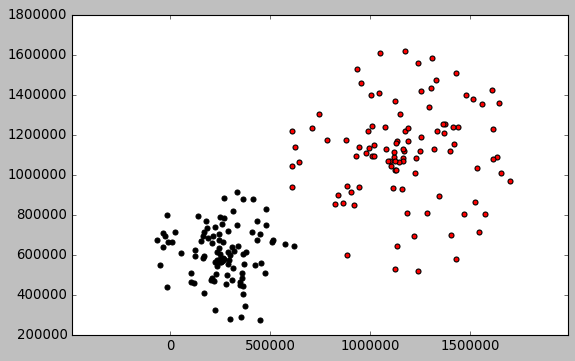

In [201]:
plt.figure(figsize=(8, 5))

ax=plt.axis('equal')

#For each position we make a black scatter
for i in range(len(positions)):

    plt.scatter(positions[i][0],positions[i][1],c=i<100 and "black" or "red")

In [204]:
nparticles = positions.shape[0]
D = positions.shape[1] ; # number of dimensions

# set the CM velocity to zero. Transpose to get last dimensions to match for
# broadcasting to work
total_momentum = np.sum(masses * velocities.transpose(), 1)
v_CM = total_momentum / np.sum(masses)
velocities -= v_CM

 
dt = 200 # time step in years. Can use day as time step by
            # writing dt = 1*day;

T = 400000 # total time to simulate in years
nsteps = int(T/dt)
print(nsteps)


write_interval = 4 # write only every 10 (or whatever you choose) time steps to save time and space
print(nsteps/write_interval)
# if writing to a file as you go, it needs to be opened now.
#output_file = open('orbits.dat','w')
# header for the output file
#output_file.write("time,xS,yS,xE,yE,d_ES\n")


# technical detail: adjust velocities to get them for a half time step
# backwards (Leap-Frog velocities are defined at the half-way points between
# "real" timesteps).

forces = np.zeros(positions.shape)
gravity(positions, masses, forces, G)
mass_array = np.tile(masses, (2,1)).transpose() # make an Nx3 version of masses
velocities -=  0.5 * (forces / mass_array)  * dt;


2000
500.0


## Modified run function
We allow any amount of planets and return a larget array of results for multiple planets

In [205]:
#@numba.njit
def smartRun(positions, velocities, forces, masses, mass_array, G, dt, nsteps, write_interval, output):

   
    for s in range(nsteps):
        # these three lines do all the calculations for the simulation
        gravity(positions, masses, forces, G)
        velocities += (forces / mass_array ) * dt
        positions = positions +  velocities * dt
        
            
        # the rest of the main loop is generating output
        if s % write_interval == 0:
            # If only using pandas dataframe without writing to a file (yet)
            index = s // write_interval # integer division

            for planet in range(len(positions)):
                    output[index,planet] = np.array(positions[planet])

            
           




In [206]:
nlines = nsteps // write_interval # we want integer division here!
output_array=np.frompyfunc(list, 0, 1)(np.empty((nlines,positions.shape[0]), dtype=object))  
smartRun(positions, velocities, forces, masses, mass_array, G, dt, nsteps, write_interval, output_array)

In [160]:
len(output_array)

250

In [145]:
print(output_array[99][1])

[7442602.4642282  5069909.69328986]


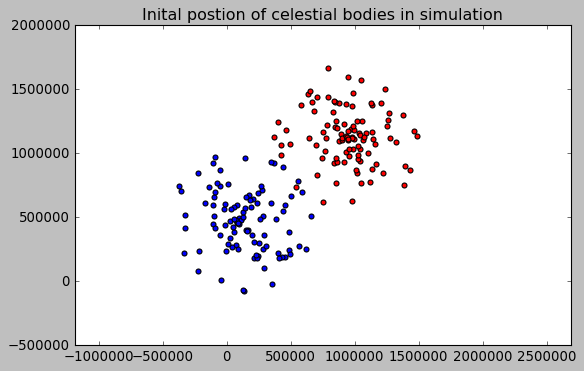

In [193]:
plt.figure(figsize=(8, 5))
ax=plt.axis('equal')
timePoint=0
plt.title("Inital postion of celestial bodies in simulation")

# (i==0 or i==101) and "black" or (i<102) and "yellow" or "red"

#For each position we make a black scatter
for i in range(len(output_array[timePoint])):
    plt.scatter(output_array[timePoint][i][0],output_array[timePoint][i][1],c= (i<100) and "blue" or "red")

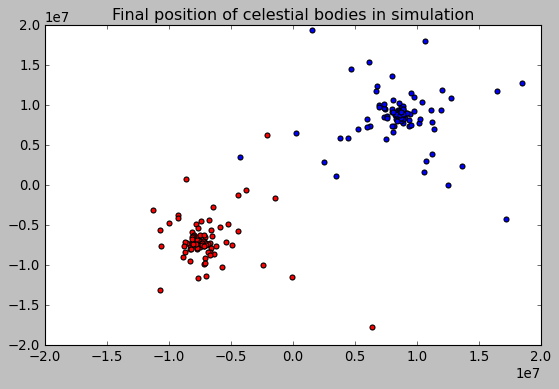

In [194]:
plt.figure(figsize=(8, 5))
ax=plt.axes()
ax.set_xlim(-2*10**7,2*10**7)
ax.set_ylim(-2*10**7,2*10**7)
timePoint=len(output_array)-1

plt.title("Final position of celestial bodies in simulation")
#For each position we make a black scatter
#(i==0 or i==101) and "black" or (i<102) and "blue" or "red"
for i in range(len(output_array[timePoint])):
    plt.scatter(output_array[timePoint][i][0],output_array[timePoint][i][1],c= (i<100) and "blue" or "red")

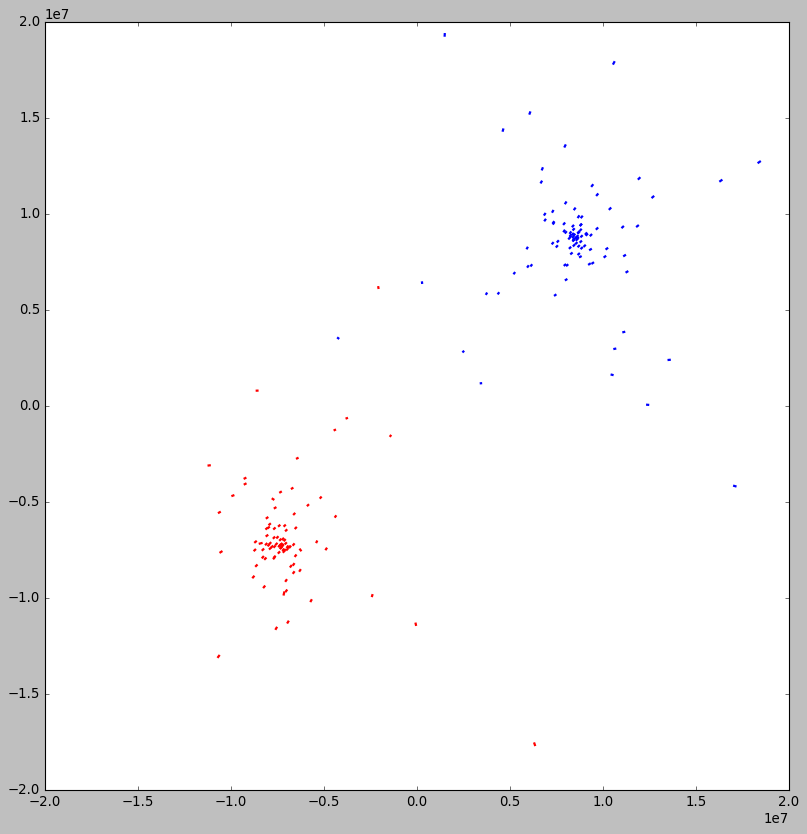

In [195]:
testfig =plt.figure(figsize=(12, 12) )
#plt.axis('equal')
ax =plt.axes()
ax.set_xlim(-2*10**7,2*10**7)
ax.set_ylim(-2*10**7,2*10**7)

import matplotlib.animation as animation
from IPython import display



#line, = ax.plot3D(x[0],y[0],z[0],lw=3)

visualLength=2
daysPerFrame=dt*write_interval

plotlays, plotcols = [9], ["black","orange","red","navy","orange","grey","gold","cyan","navy","red"]
lines = []


for index in range(len(output_array[0])):
    lwv=2
    #(index==0 or index==101) and "black" or (index<102) and "blue" or "red"
    col=(index<100) and "blue" or "red"
    
    lobj = ax.plot([],[],lw=lwv,color=col)[0]
    lines.append(lobj)


def init():
    for line in lines:
        line.set_data([],[])
    return lines



def zoomVoyager(x,y,scale):
    #print(x,y)
    ax.set_xlim(x-scale/2,x+scale/2)
    ax.set_ylim(y-scale/2, y+scale/2)

#print()
#test=output_array[0:3,3]
#print(test.tolist())
#testTest
#print(len(test))
#thisTitle = ax.text(0.5,0.85, "", bbox={'facecolor':'w', 'alpha':0.5, 'pad':5}, ha="center")



def animateMultiLines(frame,multiData,multiLine):
    #zoomVoyager(multiData[frame,9][0],multiData[frame,9][1],4)
    for i in range(len(multiData[0])):
        animateOneLine(frame,multiData[frame:frame+visualLength,i],multiLine[i])
    #ax.view_init(30,(frame/120)%360)
    t#hisTitle.set_text("Day {}".format(math.floor(frame*daysPerFrame)))


def animateOneLine(frame,data,line):
    x,y=[],[]
    for i in range(len(data)):
        x.append(data[i][0])
        y.append(data[i][1])
        #z.append(data[i][2])
        #print(z)
    #print(type())
    line.set_data(np.asarray(x),np.asarray(y))
    #line.set_3d_properties(np.asarray(z))



N = len(output_array)-visualLength

#N=100
#steps=math.floor(x.size/50)
#testAnim=animation.FuncAnimation()
#anim =animation.FuncAnimation(testfig,animate,49,interval=20,blit=cl)
anim = animation.FuncAnimation(testfig,animateMultiLines,N,fargs=(output_array,lines),interval=500,init_func=init)
writer=animation.FFMpegWriter(codec="libx264",bitrate=6000,fps=60,)
anim.save("GalaxyCollisionT_Smaller_1.mp4",writer=writer,dpi=100)
#plt.show()


In [ ]:
#Let's make scatterplot animation instead :) ?

testfig =plt.figure(figsize=(12, 12) )
#plt.axis('equal')
ax =plt.axes()
ax.set_xlim(-2*10**7,2*10**7)
ax.set_ylim(-2*10**7,2*10**7)

import matplotlib.animation as animation
from IPython import display



#line, = ax.plot3D(x[0],y[0],z[0],lw=3)

visualLength=1
daysPerFrame=dt*write_interval

plotlays, plotcols = [9], ["black","orange","red","navy","orange","grey","gold","cyan","navy","red"]
lines = []


for index in range(len(output_array[0])):
    lwv=2
    col=(index==0 or index==101) and "black" or (index<102) and "blue" or "red"
    
    lobj = ax.scatter([],[],lw=lwv,color=col)[0]
    lines.append(lobj)


def init():
    for line in lines:
        line.set_data([],[])
    return lines



def zoomVoyager(x,y,scale):
    #print(x,y)
    ax.set_xlim(x-scale/2,x+scale/2)
    ax.set_ylim(y-scale/2, y+scale/2)

#print()
#test=output_array[0:3,3]
#print(test.tolist())
#testTest
#print(len(test))
#thisTitle = ax.text(0.5,0.85, "", bbox={'facecolor':'w', 'alpha':0.5, 'pad':5}, ha="center")



def animateMultiLines(frame,multiData,multiLine):
    #zoomVoyager(multiData[frame,9][0],multiData[frame,9][1],4)
    for i in range(len(multiData[0])):
        animateOneLine(frame,multiData[frame:frame+visualLength,i],multiLine[i])
    #ax.view_init(30,(frame/120)%360)
    t#hisTitle.set_text("Day {}".format(math.floor(frame*daysPerFrame)))


def animateOneLine(frame,data,line):
    x,y=[],[]
    for i in range(len(data)):
        x.append(data[i][0])
        y.append(data[i][1])
        #z.append(data[i][2])
        #print(z)
    #print(type())
    line.set_data(np.asarray(x),np.asarray(y))
    #line.set_3d_properties(np.asarray(z))



N = len(output_array)-visualLength

#N=100
#steps=math.floor(x.size/50)
#testAnim=animation.FuncAnimation()
#anim =animation.FuncAnimation(testfig,animate,49,interval=20,blit=cl)
anim = animation.FuncAnimation(testfig,animateMultiLines,N,fargs=(output_array,lines),interval=500,init_func=init)
writer=animation.FFMpegWriter(codec="libx264",bitrate=6000,fps=60,)
anim.save("GalaxyCollisionScatter_1.mp4",writer=writer,dpi=100)
#plt.show()
